In [1]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import pylab as pl
from scipy.sparse import lil_matrix
%matplotlib inline

## Load recipes data

In [2]:
recipes = [f.path.split("/")[1] for f in os.scandir("recipe_data/") if f.is_dir() ]    
print(recipes[:10])
print("Nb of recipes: " + str(len(recipes)))

['229804', '245348', '25093', '14930', '257743', '255991', '236394', '13148', '18454', '215435']
Nb of recipes: 44069


In [3]:
recipesDict = {}
for recipe in recipes:
    recipesDict[recipe] = True

In [4]:
recipesLinks = pd.read_csv("indexes/links.csv")
recipesNames = recipesLinks["Recipe title"]
recipesID = recipesLinks["Recipe link"].map(lambda x: x.split("/")[2])
recipesIDNames = {}

for i in range(len(recipesLinks)):
    recipesIDNames[recipesID[i]] = recipesNames[i]

## Load users data and filter user with 10+ recipes only

In [5]:
with open("data/user_data.json", "r") as in_file:
    users_data = json.load(in_file)

In [6]:
len(users_data.keys())

1017178

In [7]:
for user in users_data.keys():
    users_data[user]["made"] = list(filter(lambda x: str(x) in recipesDict, users_data[user]["made"]))

In [8]:
users_data = {k: v for k, v in users_data.items() if len(v["made"]) > 30 and len(v["made"]) < 200}
users = list(users_data.keys())

In [9]:
len(users_data.keys())

16758

## Link recipes and ingredients

In [10]:
def getIngredientList(recipe):
    with open("recipe_data/" + recipe + "/data.json", "r") as input_file:
        data = json.load(input_file)
    return data["ingredients"]

In [11]:
recipeIngredients = {}
for recipe in recipes:
    recipeIngredients[recipe] = getIngredientList(recipe)

In [12]:
ingredientIDText = {}

for recipe in recipes:
    for ingredient in recipeIngredients[recipe]:
        if ingredient["id"] not in ingredientIDText:
            ingredientIDText[ingredient["id"]] = ingredient["text"]

In [13]:
len(ingredientIDText.items())

6479

In [14]:
len(ingredientIDText.keys())

6479

In [15]:
ingredientIdx, ingredientUnique = pd.factorize(list(ingredientIDText.keys()))
ingredientDict = {}
for i in range(len(ingredientUnique)):
    if ingredientUnique[i] in ingredientDict:
        print("Problem with " + str(ingredientUnique[i]))
    else:
        ingredientDict[ingredientUnique[i]] = i 

In [16]:
userIdx, userUnique = pd.factorize(users)

In [17]:
'''Xraw = lil_matrix((len(users), len(ingredientIdx)))
Xraw'''

'Xraw = lil_matrix((len(users), len(ingredientIdx)))\nXraw'

In [18]:
'''
i = 0
for user in userIdx:
    r = users_data[userUnique[user]]["made"]
    for recipe in r:
        ingredients = recipeIngredients[str(recipe)]
        for ingredient in ingredients:  
            ingredientIdx = ingredientDict[ingredient["id"]]
            Xraw[user, ingredientIdx] += 1
    i += 1
    if i % 10000 == 0:
        print(i)
'''

'\ni = 0\nfor user in userIdx:\n    r = users_data[userUnique[user]]["made"]\n    for recipe in r:\n        ingredients = recipeIngredients[str(recipe)]\n        for ingredient in ingredients:  \n            ingredientIdx = ingredientDict[ingredient["id"]]\n            Xraw[user, ingredientIdx] += 1\n    i += 1\n    if i % 10000 == 0:\n        print(i)\n'

# Save/Load matrix

# TF/IDF

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
def getUsersIngredients(recipes):
    ingredients = []
    for recipe in recipes:
        for ingredient in recipeIngredients[str(recipe)]:
            ingredients.append(ingredient["id"])
    return " ".join(ingredients)

In [21]:
usersDF = pd.DataFrame(users)
usersDF.columns = ["user"]
usersDF["recipes"] = usersDF["user"].map(lambda x: users_data[x]["made"])
usersDF["ingredients"] = usersDF["recipes"].map(lambda x: getUsersIngredients(x))

In [22]:
usersDF.head()

,user,recipes,ingredients
0,1757122,"[12177, 215038, 221952, 84450, 57014, 216688, ...",1526 1684 5233 5225 1684 1525 16157 6057 4244 ...
1,4310584,"[31804, 213797, 20867, 88052, 22122, 18304, 83...",1897 18888 2496 1526 4397 4279 16421 20236 164...
2,576774,"[11966, 10190, 23600, 20988, 77023, 22861, 893...",4575 3640 4409 4342 16403 16421 16406 6307 439...
3,6341491,"[21140, 8597, 16700, 24445, 17652, 68679, 1200...",6305 5320 2104 16157 16133 4292 4397 16410 548...
4,467039,"[16352, 149295, 11618, 25732, 19832, 13041, 46...",3868 631 4397 7428 2496 16223 1526 1525 16404 ...


In [23]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=5)
X = vectorizer.fit_transform(usersDF["ingredients"])
X.shape

(16758, 3474)

In [24]:
ingredientsMap = vectorizer.get_feature_names()    
reverseIngredientsMap = {}
for i in range(len(ingredientsMap)):
    reverseIngredientsMap[ingredientsMap[i]] = i

In [25]:
Xraw = X

## Clustering

In [26]:
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn import preprocessing

X_normalized = Xraw
X_normalized = preprocessing.normalize(X_normalized,'l1')
X_normalized.shape

model = NMF(n_components=10, init='random',random_state=0)
W = model.fit_transform(X_normalized)
H = model.components_

digits_proj = TSNE(n_components=2, verbose=2).fit_transform(W)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 16758 samples in 0.015s...
[t-SNE] Computed neighbors for 16758 samples in 4.627s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16758
[t-SNE] Computed conditional probabilities for sample 2000 / 16758
[t-SNE] Computed conditional probabilities for sample 3000 / 16758
[t-SNE] Computed conditional probabilities for sample 4000 / 16758
[t-SNE] Computed conditional probabilities for sample 5000 / 16758
[t-SNE] Computed conditional probabilities for sample 6000 / 16758
[t-SNE] Computed conditional probabilities for sample 7000 / 16758
[t-SNE] Computed conditional probabilities for sample 8000 / 16758
[t-SNE] Computed conditional probabilities for sample 9000 / 16758
[t-SNE] Computed conditional probabilities for sample 10000 / 16758
[t-SNE] Computed conditional probabilities for sample 11000 / 16758
[t-SNE] Computed conditional probabilities for sample 12000 / 16758
[t-SNE] Computed conditional probabilities for sam

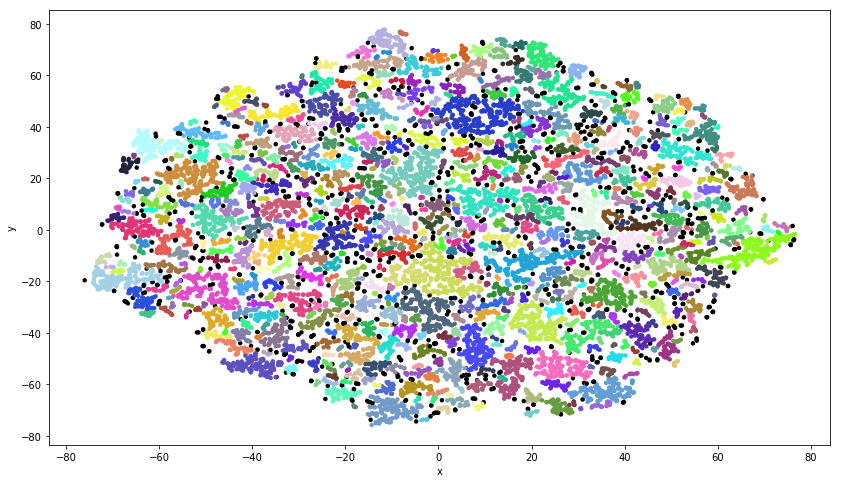

In [69]:
# plotting
def set_colors(labels, colors=None):
    import random
    r = lambda: random.randint(30,255)
    if colors is None:
        colors = 'mrgybc'*1000 + "k"
        colors = []
        for i in range(len(labels)-1):
            colors.append('#%02X%02X%02X' % (r(),r(),r()))
        colors.append('#000000')
    colored_labels = []
    for label in labels:
        colored_labels.append(colors[label])
    return colored_labels

# Fit a DBSCAN estimator
estimator = DBSCAN(eps=1.2, min_samples=5)
estimator.fit(digits_proj)
# Clusters are given in the labels_ attribute
labels = estimator.labels_

colors = set_colors(labels)
fig = plt.gcf()
fig.set_size_inches(14, 8)
plt.scatter(digits_proj[:,0], digits_proj[:,1], lw=0, s=20, c=colors,)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [70]:
from collections import Counter
feat_names = np.array(vectorizer.get_feature_names())
label_cnt = Counter(labels)

In [71]:
label_cnt[1] = 0
filtered_labels = list(filter(lambda x: x[0] != -1, label_cnt.most_common()))
filtered_labels = filtered_labels[0:10]
filtered_labels

[(149, 281),
 (55, 224),
 (150, 224),
 (97, 200),
 (171, 199),
 (62, 194),
 (120, 178),
 (146, 176),
 (157, 176),
 (11, 168)]

## Computing ingredients specificity

the specificity score $ S_{ci} $ of ingredient $i$ for cluster $c$ is computed as follow:

$$ S_{ci} = p_{ci} - p_{ji} $$
 
where:
* $ p_{ci} $ is the frequency of ingredient $i$ in cluster $c$
* $ p_{ji} $ is the frequency of ingredient $i$ in all users except those in cluster $c$

In [72]:
specificity_scores = np.zeros((len(filtered_labels), X_normalized.shape[1]))

for i in range(len(filtered_labels)):
    label = filtered_labels[i][0]
        
    distrib_pos = X_normalized[labels==label,:].sum(axis=0)
    distrib_neg = X_normalized[labels!=label,:].sum(axis=0)

    # normalize
    distrib_pos = distrib_pos / distrib_pos.sum()
    distrib_neg = distrib_neg / distrib_neg.sum()
    
    specificity_scores[i] = (distrib_pos - distrib_neg)
    
    distrib_pos = np.array(distrib_pos)[0]
    distrib_neg = np.array(distrib_neg)[0]
    
    print("CLUSTER: ", label, "-"*40 )
    for feat_idx in specificity_scores[i].argsort()[::-1][:10]:
        ingredient_name = ingredientIDText[feat_names[feat_idx]]
        print("-- ", ingredient_name ,specificity_scores[i][feat_idx], distrib_pos[feat_idx], distrib_neg[feat_idx])

CLUSTER:  149 ----------------------------------------
--  2 teaspoons active dry yeast 0.018629253828 0.0240218803468 0.00539262651876
--  3 cups bread flour 0.0145200427705 0.0183037238703 0.00378368109978
--  2 1/4 teaspoons bread machine yeast 0.00458669659028 0.00605820880829 0.00147151221801
--  2 cups vegetable oil for frying 0.00422812953037 0.00821424558322 0.00398611605285
--  1 teaspoon sesame oil 0.003123418935 0.00584652074763 0.00272310181263
--  3 tablespoons dry milk powder 0.00260799135633 0.00352240307096 0.000914411714633
--  2 tablespoons cornmeal 0.00241059384662 0.00422687870691 0.00181628486029
--  3 cups whole wheat flour 0.00236520372841 0.00510837645867 0.00274317273026
--  1 (.25 ounce) package rapid rise yeast 0.00198875158035 0.00258735024314 0.000598598662789
--  1/2 teaspoon kosher salt 0.00190906052396 0.00471700998992 0.00280794946596
CLUSTER:  55 ----------------------------------------
--  1 teaspoon sesame oil 0.00409620281957 0.00681692554694 0.0027

CLUSTER:  11 ----------------------------------------
--  1 teaspoon sesame oil 0.0131657806759 0.0158092685469 0.00264348787107
--  1 1/3 tablespoons grated fresh ginger 0.0108637390557 0.0147051928874 0.00384145383179
--  3 tablespoons rice wine vinegar 0.00985428673748 0.0117231367162 0.00186884997875
--  2 cups vegetable oil for frying 0.00532920342637 0.0093327916252 0.00400358819883
--  1 tablespoon chile paste 0.00470331447189 0.00572692742658 0.00102361295469
--  16 egg roll wrappers 0.00440183811115 0.00515378789383 0.000751949782677
--  3 tablespoons oyster sauce 0.00409181412834 0.00469976483573 0.000607950707387
--  1 1/2 teaspoons reduced-sodium soy sauce 0.00406114925072 0.00539386066329 0.00133271141258
--  1 tablespoon fish sauce 0.00357033577283 0.00440173560022 0.000831399827396
--  2 tablespoons toasted sesame seeds 0.00351995982262 0.00584268786405 0.00232272804143


## Computing similarity between clusters and recipes

To compute the similarity score between a recipe and a cluster, we compute the average specificity of the ingredients of the recipe for the cluster:

$$ S_{CR} = \frac{1}{|R|} \sum_{i \in R} s_{ci} $$

In [73]:
recipeIngredientsList = {}
for recipe in recipeIngredients:
    recipeIngredientsList[recipe] = list(map(lambda x: x["id"],recipeIngredients[recipe]))

In [74]:
def computeRecipesSimilarity(recipe, cluster_index):
    ingredients = recipeIngredientsList[recipe]
    
    similarity = np.array(list(map(lambda x: specificity_scores[cluster_index][reverseIngredientsMap[x]], filter(lambda x: x in reverseIngredientsMap, ingredients)))).mean()
    return similarity

In [75]:
recipesClusterDF = pd.DataFrame()
for i in range(len(filtered_labels)):
    cluster = filtered_labels[i][0]
    recipesClusterDF[cluster] = list(map(lambda x: computeRecipesSimilarity(x, i), recipes))

/home/nathan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice.
/home/nathan/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [76]:
list(filter(lambda x: x in reverseIngredientsMap, recipeIngredientsList[recipes[0]]))

[]

In [77]:
recipeIngredients[recipes[0]]

[{'id': '6300', 'text': '1 cup vegetable shortening'},
 {'id': '1526', 'text': '1 cup white sugar'},
 {'id': '16278', 'text': '1/4 cup milk'},
 {'id': '16317', 'text': '2 eggs'},
 {'id': '16424', 'text': '1 teaspoon vanilla extract'},
 {'id': '1684', 'text': '3 cups all-purpose flour'},
 {'id': '16421', 'text': '1 teaspoon salt'},
 {'id': '2359', 'text': '1 teaspoon baking soda'},
 {'id': '16157', 'text': '1/4 cup butter'},
 {'id': '1527', 'text': "3 cups confectioners' sugar"},
 {'id': '16424', 'text': '1 1/2 teaspoons vanilla extract, or more to taste'},
 {'id': '16278', 'text': '2 tablespoons milk, or as needed'}]

In [78]:
clustersOrderedRecipesDF = pd.DataFrame()
for cluster in recipesClusterDF:
    clustersOrderedRecipesDF[cluster] = list(map(lambda x: recipes[x], recipesClusterDF.sort_values([cluster], ascending=False)[cluster].index))

In [79]:
clustersOrderedRecipesDF.head()

,149,55,150,97,171,62,120,146,157,11
0,230162,176216,21660,161745,146824,22970,7267,165837,163703,233736
1,6982,165837,14855,25182,247194,16700,70638,176216,14855,165837
2,6761,233736,247375,8465,20797,242342,139680,233736,245961,176216
3,257199,13491,245961,220411,81548,246530,221067,256166,247375,49488
4,23419,86323,163703,246725,234187,215476,19466,150107,21660,8919


In [80]:
clustersOrderedRecipesTitleDF = pd.DataFrame()
for cluster in clustersOrderedRecipesDF:
    clustersOrderedRecipesTitleDF[cluster] = clustersOrderedRecipesDF[cluster].map(lambda x: recipesIDNames[x])

In [81]:
clustersOrderedRecipesTitleDF.head(10)

,149,55,150,97,171,62,120,146,157,11
0,Softest Soft Bread with Air Pockets Using Brea...,Krystal's Perfect Marinade for BBQ or Grilled ...,Chile Cheese Squares,Hot Mint Malt,Basil and Pesto Hummus,Salsa Chicken Burrito Filling,Best Cheesecake on Earth,Super Easy Dip for Artichokes or Asparagus,Green Chili Eggs,Chinese Tomato and Egg Soup
1,Peanut Butter Bread I,Super Easy Dip for Artichokes or Asparagus,Suzy's Potato Skins,Fruit Dip VII,The Best Dry-Roasted Chickpea Recipe,Salsa Chicken,Oven Roasted Stuffed Chicken Breasts,Krystal's Perfect Marinade for BBQ or Grilled ...,Suzy's Potato Skins,Super Easy Dip for Artichokes or Asparagus
2,Tasty Buns,Chinese Tomato and Egg Soup,Jan's Chile Con Queso,Cool Whipped Frosting,Extra Easy Hummus,Fiesta Slow Cooker Shredded Chicken Tacos,Honey Pie from Sifnos,Chinese Tomato and Egg Soup,White Bean Chicken Chili from Knorr®,Krystal's Perfect Marinade for BBQ or Grilled ...
3,Thin Crust Pizza Dough,Butterhorn Rolls,White Bean Chicken Chili from Knorr®,Whipped Cream Mousse Frosting,Roasted Chickpeas,Real Nacho Cheese Sauce,Creamy Ricotta Pie,Homemade Hoisin Sauce,Jan's Chile Con Queso,Angelyn's Marinade
4,Easiest Focaccia Recipe,Yeast Dumplings,Green Chili Eggs,Fudge Marble Pound Cake,Savory Saffron Chicken Polow,Erin's Year Round Party Dip,Sweet Pie,Quick Egg Roll Dipping Sauce,Chile Cheese Squares,Grilled Asian Chicken
5,Valentino's Pizza Crust,Potato Bread III,Mexican-Style Deviled Eggs,Amish Cinnamon Bread,Garbanzo Bean Chocolate Cake (Gluten Free!),Chicken Taco Filling,Chunky Monkey Grilled Cheese,Grilled Asian Chicken,Beth's Tex Mex Dip,Sesame Ginger Sauce
6,Buttery Pan Rolls,Grandma's English Muffin Bread,My Favorite Mexican Rice,Mom's Chocolate Chip Cookies,Chickpea Soup II,Baked Chicken with Salsa and Sour Cream,Ricotta and lemon cheesecake,Angelyn's Marinade,Chicken Taco Filling,Homemade Hoisin Sauce
7,Fantastic Focaccia Bread,Portuguese Sweet Bread IV,Caitlin's Mexican Rice,Award Winning Soft Chocolate Chip Cookies,Bacon Dumplings,Easy Cheesy Bean Dip,Ricotta Stuffed Zucchini,Sesame Ginger Sauce,Easy Cheesy Bean Dip,Quick Egg Roll Dipping Sauce
8,Batter Buns,Herman Bread,Rice With Olives And Green Chile Peppers,Lucky Cakes,Herbed Potatoes with Sauce,Ground Beef for Tacos,Italian Cream Cheese and Ricotta Cheesecake,Soy-Sesame Dressing,Salsa Chicken,Soy-Sesame Dressing
9,Unbelievable Rolls,Best Basic Sweet Bread,My Little Secret,Eggnog Pudding,Baked Mushroom Rice,Taco Bean Dip,Camille's Crustless Ricotta Pie,Carrot Hot Dogs,Erin's Year Round Party Dip,Carrot Hot Dogs


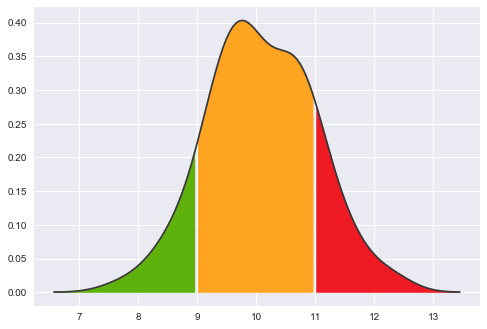

In [447]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plotHealthHistogram(data):
    traffic_red = '#F01A24'
    traffic_orange = '#FFA420'
    traffic_green = '#5EB20B'
        
    x0 = 9
    x1 = 11

    #plotting the PDF (do this before plotting anything else)
    ax = sns.distplot(data, hist=False,color='#383838')
    kde_x, kde_y = ax.lines[0].get_data()

    #plotting the two lines
    #p1 = plt.axvline(x=x0,color='#EF9A9A')
    #p2 = plt.axvline(x=x1,color='#EF9A9A')


    ax.fill_between(kde_x, kde_y, where=(kde_x<x0), 
                    interpolate=False, color=traffic_green)

    ax.fill_between(kde_x, kde_y, where=(kde_x>=x0) & (kde_x<=x1) , 
                    interpolate=False, color=traffic_orange)

    ax.fill_between(kde_x, kde_y, where=(kde_x>=x1) , 
                    interpolate=False, color=traffic_red)

    plt.show()
    
plotHealthHistogram(np.random.randn(100) + 10)